In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection, feature_selection, pipeline, ensemble, tree, datasets
from ipywidgets import interact
from sympy import *
from sympy.stats import *
from IPython.display import Markdown, Latex

# Anahat:

- Lojistik Regresyon
    - Logit icin lineer bir fonksiyon: ax + b
    - REGULARIZASYON !
    - Katsayilarin yorumlanmasi: ax+b'de x'in 1 artmasi ne anlama gelecek?
- Tasniflendirme metrikleri
    - Accuracy
    - Confusion Matrix
    - Dengesiz veriler
        - Precision/Recall
        - F1-Score
    - ROC/AUC




# Tasniflendirme

`Tasniflendirme icin MLE` bolumunde, tasniflendirme varsayimlari uzerinden giderek likelihood icin maksimize edilmesi gereken bir ifade bulmus, buna bagli olarak da *Ikili Capraz-Entropi* kayip fonksiyonu elde etmistik.

In [2]:
# Ornek dataset uretimi
X, y = datasets.make_classification(n_samples=20, n_features=1, n_redundant=0, n_informative=1, n_clusters_per_class=1, random_state=1)
dataset = pd.DataFrame(X).add_prefix('x').assign(y=y)
dataset.head()

,x0,y
0,0.984424,1
1,-0.330421,0
2,1.760128,1
3,-1.095697,0
4,-1.202688,0


## Olasilik - Odds - Logit

Hipotez fonksiyonumuz icin 

$$ h(x) = \frac{1}{1 + e^{-g(x)}} $$

formunda, $[0, 1]$ aralidinda deger veren bir fonksiyon  kullanacagimizi soylemistik.

*Logit* $g(x)$ konusunda ise gorece ozguruz.

# Lineer bir fonksiyon olarak Logit

Lineerlik tam olarak lojistik regresyonun neresinde?

Lineer regresyonda tahmini yapan hipotez fonksiyonumuz $h(x)$ lineer bir ifadeydi: $h(X) = b_0 + b_1 X_1 + b_2 X_2 + ... + b_n X_n$.

> Lojistik regresyonda ayni lineer ifadeyi sonsuz aralikta degerler alabilen *logit* degeri olarak kullanabiliriz:




$$g(x) = XA + b$$
$$h(x) = \frac{1}{1 + e^{-g(x)}} $$

In [3]:
a, b, x = symbols('a, b, x')
h = Function("h")
g = Function("g")

In [4]:
Y = IndexedBase("Y")
Xv = IndexedBase("X")
Yhat = IndexedBase("Yhat")
i, m = symbols("i m")

In [5]:
log_likelihood = Sum(Y[i] * log(1/(1+exp(-Xv[i]*a - b))) + (1 - Y[i]) * log(1 - 1/(1+exp(-a*Xv[i] - b))), (i, 0, m-1))
display(Markdown("Log-likelihood:"))
log_likelihood

Log-likelihood:

Sum((1 - Y[i])*log(1 - 1/(exp(-a*X[i] - b) + 1)) + log(1/(exp(-a*X[i] - b) + 1))*Y[i], (i, 0, m - 1))

In [6]:
display(Markdown("Ikili capraz-entropi maliyeti:"))
bce = -log_likelihood
bce

Ikili capraz-entropi maliyeti:

-Sum((1 - Y[i])*log(1 - 1/(exp(-a*X[i] - b) + 1)) + log(1/(exp(-a*X[i] - b) + 1))*Y[i], (i, 0, m - 1))

Asagidaki sekilde verilen siniflari ayirmak icin bir lojistik regresyon uygulayacak olsaydik, $b=0$ icin maliyet soyle olacakti:

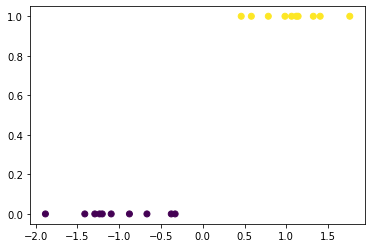

In [7]:
plt.scatter(X, y, c=y);

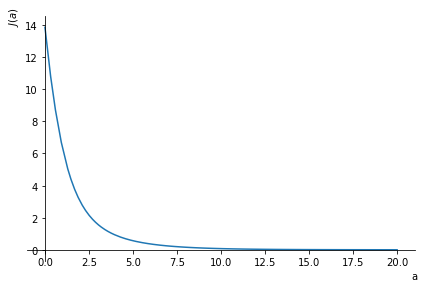

In [8]:
pouu = -log_likelihood.subs(Xv, Array(X.ravel())).subs(Y, Array(y)).subs(m, len(y)).doit()
plot((pouu.subs(b, 0)), (a, 0, 20), ylabel="$J(a)$");

Maliyet, buyuyen $a$ ile kuculmekte ancak minimaya ulasmamaktadir.

Ornegin, $a=12.5$ icin elde edilen hipotez fonksiyonuna bakacak olursak:

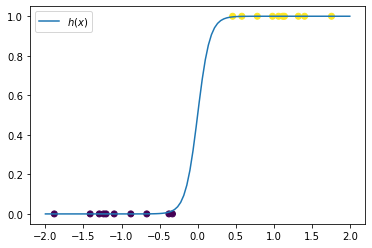

In [9]:
t = np.linspace(-2, 2, 100)
plt.scatter(X, y, c=y);
plt.plot(t, 1/(1 + np.exp(-12.5 * t)), label="$h(x)$")
plt.legend();

Asagidaki interaktif hucrede $a$ ve $b$'nin degerleriyle oynayarak olusan *maliyet* degerlerini inceleyiniz.

In [10]:
def createSigmoid(a, b):
    def sigmoid(x):
        return 1 / (1 + np.exp(-a*x - b))
    return sigmoid

@interact(a_=(-10, 100, 0.1), b_=(-10, 10, 0.1))
def vizSigmoid(a_=1.0, b_=0.0):
    rng = np.linspace(-2, 2, 1000)
    plt.scatter(X, y, c=y, cmap='rainbow');
    plt.plot(rng, createSigmoid(a_, b_)(rng), color='red')
    maliyet = pouu.subs(a, a_).subs(b, b_)
    lkl = lambdify(h, maliyet)(createSigmoid(a_, b_))
    plt.title(f"Maliyet $={lkl}$")
    plt.grid()

interactive(children=(FloatSlider(value=1.0, description='a_', min=-10.0), FloatSlider(value=0.0, description=…

Bu senaryoda, $b=0$ icin $a$ katsayisini yukselttikce *maliyet* degerinin dusmeye devam ettigini goruyorsunuz.



Teorik olarak, ancak $a=\infty$ oldugunda *log-likelihood* maksimum olacagindan, bu durum optimizasyon algoritmalarimizda sayisal stabiliteyi bozabilir.

> Likelihood yukseldigi surece -bir diger deyisle maliyet dustugu surece- optimizasyon algoritmasi $a$'yi arttirmaya devam edecek.


## Regularizasyon

Maliyet fonksiyonumuza katsayinin mutlak degeri buyudukce buyuyen bir terim eklemek, maliyet fonksiyonumuzu nasil etkilerdi?

Katsayinin mutlak degeri ile buyuyen bu terim, ornek olarak $a^2$ olabilirdi:

In [11]:
lamda = Symbol("lambda")

In [12]:
-log_likelihood + lamda * a**2

a**2*lambda - Sum((1 - Y[i])*log(1 - 1/(exp(-a*X[i] - b) + 1)) + log(1/(exp(-a*X[i] - b) + 1))*Y[i], (i, 0, m - 1))

Regularizasyon kullanilmasi durumunda maliyet fonksiyonu, bu ornek icin asagidaki sekle donusmektedir:

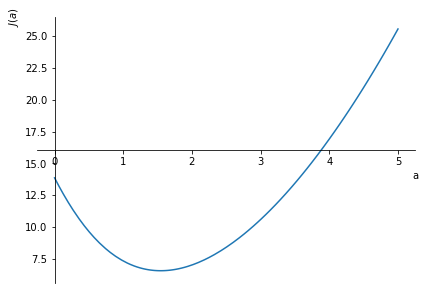

In [13]:
plot((pouu.subs(b,0) + lamda * a**2).subs(lamda, 1), (a, 0, 5), ylabel="$J(a)$");

In [14]:
@interact
def vizregule(lamda_=(0.0, 3.0, 0.1)):
    plot((pouu.subs(b,0) + lamda * a**2).subs(lamda, lamda_), (a, 0, 15), ylabel="$J(a)$",
        xlim=(0, 15),
        ylim=(0, 50),
        grid=True,
        title=f"$\lambda = {lamda_}$");

interactive(children=(FloatSlider(value=1.5, description='lamda_', max=3.0), Output()), _dom_classes=('widget-…

### `scikit-learn` ile lojistik regresyon ornegi

#### Tek boyutta lojistik regresyon

In [15]:
model1b = linear_model.LogisticRegression(C=1)
model1b.fit(X, y)

LogisticRegression(C=1)

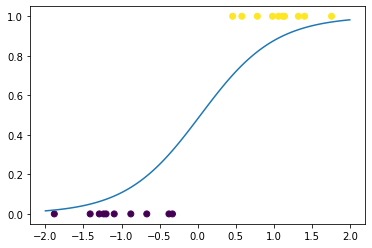

In [16]:
plt.scatter(X, y, c=y)
plt.plot(t, model1b.predict_proba(t[:, None])[:, 1], label="$h(x)$")

`sklearn` `LogisticRegression` sinifi, regularizasyon parametresi olarak `C` argumanini kullanmaktadir. Bu argumanin etkisi, yukarida gormus oldugumuz $\lambda$ parametresi ile ters orantilidir.

$$C \approx \frac{1}{\lambda}$$

In [17]:
from ipywidgets import FloatLogSlider

In [18]:
@interact
def logreg1bviz(C=FloatLogSlider(min=-10, max=10, value=128)):
    model1b = linear_model.LogisticRegression(C=C)
    model1b.fit(X, y)
    plt.scatter(X, y, c=y)
    plt.plot(t, model1b.predict_proba(t[:, None])[:, 1], label="$h(x)$")
    plt.legend()
    plt.title(f"$C={C:8f}$")
    plt.grid()

interactive(children=(FloatLogSlider(value=128.0, description='C', max=10.0, min=-10.0), Output()), _dom_class…

#### 2 boyutta lojistik regresyon

In [19]:
X, y = datasets.make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=1)

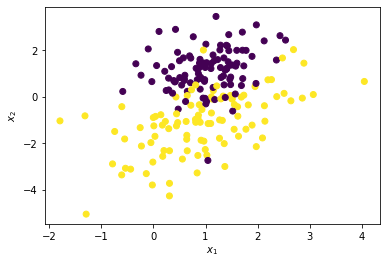

In [20]:
plt.scatter(*X.T, c=y);
plt.xlabel("$x_1$")
plt.ylabel("$x_2$");

In [21]:
model = linear_model.LogisticRegression()

In [22]:
model

LogisticRegression()

#### Egitim

In [23]:
model.fit(X, y)

LogisticRegression()

#### Tahmin

`LogisticRegression` predict metodu, olasiligi hesaplayip %50 uzerinde ise 1, tersi durumda 0 ciktisi verir.

In [24]:
model.predict([[4, 2]])

array([0])

In [25]:
model.predict([[6, 2]])

array([1])

##### Aciklama

In [26]:
model.coef_

array([[ 0.97871558, -2.11660883]])

In [27]:
model.intercept_

array([-0.69321901])

In [28]:
ornek = [[4, 2]]

In [29]:
ornek @ model.coef_ .T + model.intercept_

array([[-1.01157437]])

In [30]:
1 / (1 + np.exp(-(ornek @ model.coef_ .T + model.intercept_)))

array([[0.26667186]])

`predict_proba`

In [31]:
model.predict_proba([[4, 2]])

array([[0.73332814, 0.26667186]])

#### Karar sinirinin gosterimi

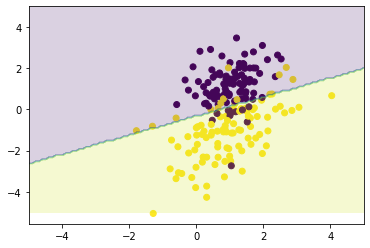

In [32]:
plt.scatter(*X.T, c=y)
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
Xgrid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(Xgrid).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2);

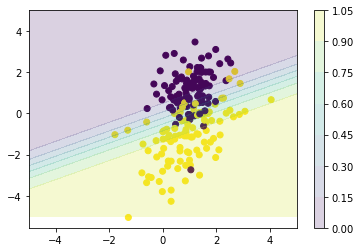

In [33]:
plt.scatter(*X.T, c=y)
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
Xgrid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict_proba(Xgrid)[:, 1].reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2)
plt.colorbar();

## Bulunan katsayilarin yorumlanmasi

Katsayilarimizin lineer bir fonksiyonu olarak *logit* degeri hesapladigimizi hatilarlayalim:

$$p = \frac{1}{1 + e^{-Z}}$$

$$Z = XA = logit$$

Bu durumda $i$'nci *feature*'daki birim artis, *logit*'de $X_i$'nin katsayisi $A_i$ kadar artis meydana getirir.

In [34]:
model.decision_function([[1, 2]]) - model.decision_function([[1, 1]])

array([-2.11660883])

In [35]:
model.coef_[0, 1]

-2.11660882823466

Bu degisikligi, *odds* cinsinden de akla daha yatkin olarak aciklayabiliriz:

In [36]:
def odds(p):
    return p / (1 - p)

In [37]:
odds(model.predict_proba([[1, 2]])[0, -1]) / odds(model.predict_proba([[1, 1]])[0, -1])

0.12043936734647388

In [38]:
np.exp(model.coef_[0, 1])

0.12043936734647386

Buna gore, $X_i$ *feature*'i 1 arttiginda hedef degiskenin + sinif olma sansi $e^{A_i}$ kadar artar.

## Lojistik Regresyon Modelinin Guclendirilmesi

Polinomiyel regresyondan hatirladigimiz uzere, orijinal degiskenlerin polinomiyellerini modele ekleyerek daha kompleks temsiller elde edebiliriz.

In [39]:
Q, w = datasets.make_moons(noise=0.2, random_state=1)

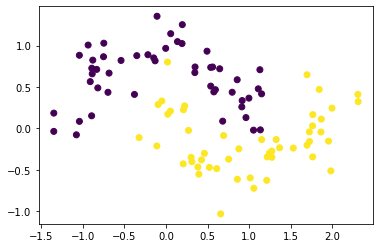

In [40]:
plt.scatter(*Q.T, c=w);

In [41]:
model = linear_model.LogisticRegression(C=1)
model.fit(Q, w)

LogisticRegression(C=1)

In [42]:
model.score(Q, w)

0.85

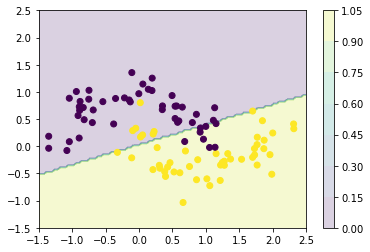

In [43]:
qq1, qq2 = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.5, 2.5, 100))
Qgrid = np.c_[qq1.ravel(), qq2.ravel()]
Z = model.predict(Qgrid).reshape(qq1.shape)
plt.contourf(qq1, qq2, Z, alpha=0.2)
plt.colorbar()
plt.scatter(*Q.T, c=w);

In [44]:
from sklearn import preprocessing, pipeline

In [45]:
boru = pipeline.Pipeline([
    ('poly', preprocessing.PolynomialFeatures(degree=32, include_bias=False)),
    ("scaler", preprocessing.StandardScaler()),
    ('log', linear_model.LogisticRegression(C=100, max_iter=10000))
])

boru.fit(Q, w)
boru.score(Q, w)

1.0

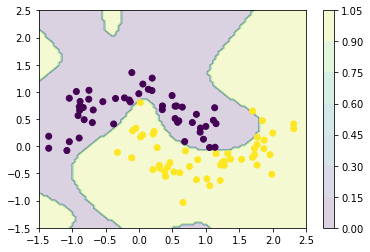

In [46]:
qq1, qq2 = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.5, 2.5, 100))
Qgrid = np.c_[qq1.ravel(), qq2.ravel()]
Z = boru.predict(Qgrid).reshape(qq1.shape)
plt.contourf(qq1, qq2, Z, alpha=0.2)
plt.colorbar()
plt.scatter(*Q.T, c=w);

In [47]:
from ipywidgets import interact, FloatLogSlider

Asagidaki interaktif hucrede, farkli polinomiyel dereceleri ve farkli `C` parametreleri icin modelin ogrenecegi karar sinirlarini inceleyebilirsiniz:

In [65]:
@interact(
    eC=(-5,5,1),
    degree=(1, 32, 1)
    )
def polyviz(eC=0, degree=1):
    boru = pipeline.Pipeline([
        ("fu", pipeline.FeatureUnion([
            # ("sinx", preprocessing.FunctionTransformer(np.sin)),
            ('poly', preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
        ])),
        ("scaler", preprocessing.StandardScaler()),
        ('log', linear_model.LogisticRegression(C=10**eC, max_iter=10000))
        ])
    X = Q

    boru.fit(X, w)
    boru.score(X, w)
    qq1, qq2 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
    Qgrid = np.c_[qq1.ravel(), qq2.ravel()]
    Z = boru.predict(Qgrid).reshape(qq1.shape)
    plt.contourf(qq1, qq2, Z, alpha=0.2)
    plt.colorbar()
    plt.scatter(*X.T, c=w)
    plt.title("Accuracy: {:.2f}".format(boru.score(X, w)));

interactive(children=(IntSlider(value=0, description='eC', max=5, min=-5), IntSlider(value=1, description='deg…

#### Tek boyuta kisa bir donus

Orijinal *feature* uzayinda karar sinirlari non-lineer gibi gozukse de, polinomiyel donusumu ile olusturdugumuz ve modele vermis oldugumuz yeni *feature* uzayinda bulunan karar sinirlari hala dogrusal olacaktir.

In [67]:
df = pd.DataFrame({"X": [-3, -2, -1, 0, 1, 2], "y": [1, 1, 0, 0, 1, 1]})

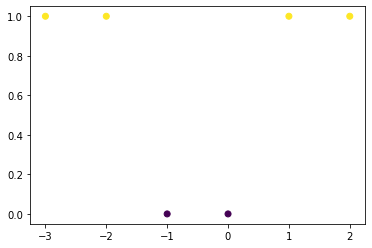

In [70]:
plt.scatter(df.X, df.y, c=df.y);

Datasetimize yeni bir feature olarak $x^2$ ekleyip modellemeyi bu sekilde yapalim:

In [102]:
pmodel = pipeline.Pipeline([
    ("poly", preprocessing.PolynomialFeatures(degree=2, include_bias=False)), 
    ("log", linear_model.LogisticRegression(C=100, max_iter=10000))])
pmodel.fit(df[["X"]], df.y)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('log', LogisticRegression(C=100, max_iter=10000))])

Orijinal (tek boyutlu) feature uzayinda hipotez fonksiyonunun ciktisini gozlemlersek karar sinirinin lineer olmadigini gorecegiz:

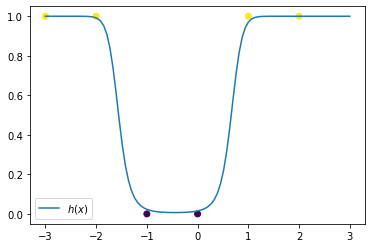

In [103]:
t = np.linspace(-3, 3, 100)
plt.plot(t, pmodel.predict_proba(pd.DataFrame({"X": t}))[:, 1], label="$h(x)$")
plt.scatter(df.X, df.y, c=df.y);
plt.legend();

Fakat modelin uzerinde egitilmis oldugu feature uzayi $[x, x^2]$'de karar sinirlarina baktigimizda:

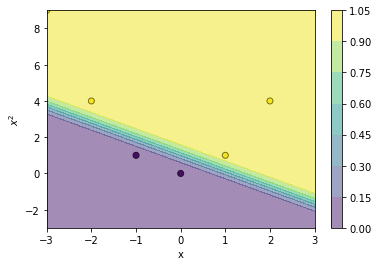

In [109]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 9, 100))
plt.scatter(df.X, df.X**2, c=df.y, edgecolors="black");
plt.contourf(xx, yy, pmodel.named_steps['log'].predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape), alpha=0.5, vmin=0, vmax=1);
plt.colorbar()
plt.xlabel("x")
plt.ylabel("$x^2$");


Modelin uzerinde egitildigi, donusume ugramis bu uzayda karar sinirlarinin hala dogrusal oldugunu gormekteyiz.

# Tasniflendirme metrikleri

In [49]:
np.random.choice([0, 1])

1

In [50]:
from sklearn import metrics

#### Accuracy

In [51]:
y = np.array([1, 1, 1, 0, 0, 1, 0, 1, 0]) # gercek etiketler
yhat = np.array([1, 1, 0, 0, 0, 1, 1, 1, 0]) # tahminler

In [52]:
(y == yhat).mean()

0.7777777777777778

In [53]:
(y == yhat).sum() / len(y)

0.7777777777777778

In [54]:
metrics.accuracy_score(y, yhat)

0.7777777777777778

#### Confusion Matrix

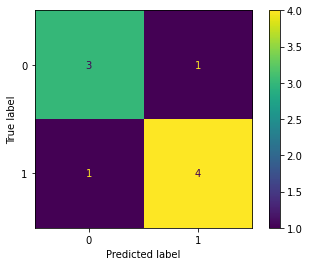

In [55]:
metrics.ConfusionMatrixDisplay.from_predictions(y, yhat)

In [56]:
y == yhat

array([ True,  True, False,  True,  True,  True, False,  True,  True])

#### Precision

In [57]:
metrics.precision_score(y, yhat)

0.8

In [58]:
(yhat[yhat == 1] == y[yhat == 1]).mean()

0.8

#### Recall

In [59]:
metrics.recall_score(y, yhat)

0.8

#### F1 score

In [60]:
metrics.f1_score(y, yhat)

0.8000000000000002

In [61]:
2*.8*.8/(1.6)

0.8000000000000002

In [62]:
metrics.accuracy_score([0]*90 + [1]*5, [0]*93 + [1]*2,)

0.968421052631579

In [63]:
metrics.f1_score([0]*90 + [1]*5, [0]*93 + [1]*2,)

0.5714285714285715

#### ROC AUC